In [30]:
#Importing Neccessary libraries and modules

from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

import pandas as pd
import seaborn as sn
import sklearn.metrics 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

In [2]:
import torch.nn.functional as nnf

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda'

In [7]:
curr_working_dir = os.getcwd()
project_name = 'demo_1'
imb_type = 'exp' # samling long-tailed training set with an exponetially-decaying function
imb_factor = 0.01 # imbalance factor = 100 = 1/0.01
    
nClasses = 100  # number of classes in CIFAR100-LT with imbalance factor 100
encoder_num_layers = 13 # network architecture is VGG16
batch_size = 16 # batch size 
isPretrained = True

torch.cuda.device_count()
torch.cuda.empty_cache()
save_dir = path.join(curr_working_dir, 'exp', project_name)
if not os.path.exists(save_dir): os.makedirs(save_dir)

    
log_filename = os.path.join(save_dir, 'train.log')


In [14]:
path_to_DB = './datasets'
if not os.path.exists(path_to_DB): os.makedirs(path_to_DB)
_ = torchvision.datasets.CIFAR10(root=path_to_DB, train=True, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets\cifar-10-python.tar.gz to ./datasets


In [9]:
path_to_DB='C:\\Users\\HP\\CIFAR100_L_T\\datasets'
path_to_DB

'C:\\Users\\HP\\CIFAR100_L_T\\datasets'

In [10]:
def get_img_num_per_cls(cls_num, total_num, imb_type, imb_factor):
    # This function is excerpted from a publicly available code [commit 6feb304, MIT License]:
    # https://github.com/kaidic/LDAM-DRW/blob/master/imbalance_cifar.py
    img_max = total_num / cls_num
    img_num_per_cls = []
    if imb_type == 'exp':
        for cls_idx in range(cls_num):
            num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
            img_num_per_cls.append(int(num))
    elif imb_type == 'step':
        for cls_idx in range(cls_num // 2):
            img_num_per_cls.append(int(img_max))
        for cls_idx in range(cls_num // 2):
            img_num_per_cls.append(int(img_max * imb_factor))
    else:
        img_num_per_cls.extend([int(img_max)] * cls_num)
    return img_num_per_cls


def gen_imbalanced_data(img_num_per_cls, imgList, labelList):
    # This function is excerpted from a publicly available code [commit 6feb304, MIT License]:
    # https://github.com/kaidic/LDAM-DRW/blob/master/imbalance_cifar.py
    new_data = []
    new_targets = []
    targets_np = np.array(labelList, dtype=np.int64)
    classes = np.unique(targets_np)
    # np.random.shuffle(classes)  # remove shuffle in the demo fair comparision
    num_per_cls_dict = dict()
    for the_class, the_img_num in zip(classes, img_num_per_cls):
        num_per_cls_dict[the_class] = the_img_num
        idx = np.where(targets_np == the_class)[0]
        #np.random.shuffle(idx) # remove shuffle in the demo fair comparision
        selec_idx = idx[:the_img_num]
        new_data.append(imgList[selec_idx, ...])
        new_targets.extend([the_class, ] * the_img_num)
    new_data = np.vstack(new_data)
    return (new_data, new_targets)



class CIFAR100LT(Dataset):
    def __init__(self, set_name='train', imageList=[], labelList=[], labelNames=[], isAugment=True):
        self.isAugment = isAugment
        self.set_name = set_name
        self.labelNames = labelNames
        if self.set_name=='train':            
            self.transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
        
        self.imageList = imageList
        self.labelList = labelList
        self.current_set_len = len(self.labelList)
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):   
        curImage = self.imageList[idx]
        curLabel =  np.asarray(self.labelList[idx])
        curImage = PIL.Image.fromarray(curImage.transpose(1,2,0))
        curImage = self.transform(curImage)     
        curLabel = torch.from_numpy(curLabel.astype(np.float32)).unsqueeze(0).unsqueeze(0)
        return curImage, curLabel


In [11]:
path_to_DB = path.join(path_to_DB, 'cifar-100-python')
## Unpickling data files
datasets = {}
dataloaders = {}

setname = 'meta'
with open(os.path.join(path_to_DB, setname), 'rb') as obj:
    labelnames = pickle.load(obj, encoding='bytes')
    labelnames = labelnames[b'fine_label_names']
for i in range(len(labelnames)):
    labelnames[i] = labelnames[i].decode("utf-8") 
    
    
setname = 'train'
with open(os.path.join(path_to_DB, setname), 'rb') as obj:
    DATA = pickle.load(obj, encoding='bytes')
imgList = DATA[b'data'].reshape((DATA[b'data'].shape[0],3, 32,32))
labelList = DATA[b'fine_labels']
total_num = len(labelList)
img_num_per_cls = get_img_num_per_cls(nClasses, total_num, imb_type, imb_factor)
new_imgList, new_labelList = gen_imbalanced_data(img_num_per_cls, imgList, labelList)
datasets[setname] = CIFAR100LT(
    imageList=new_imgList, labelList=new_labelList, labelNames=labelnames,
    set_name=setname, isAugment=setname=='train')
print('#examples in {}-set:'.format(setname), datasets[setname].current_set_len)



setname = 'test'
with open(os.path.join(path_to_DB, setname), 'rb') as obj:
    DATA = pickle.load(obj, encoding='bytes')
imgList = DATA[b'data'].reshape((DATA[b'data'].shape[0],3, 32,32))
labelList = DATA[b'fine_labels']
total_num = len(labelList)
datasets[setname] = CIFAR100LT(
    imageList=imgList, labelList=labelList, labelNames=labelnames,
    set_name=setname, isAugment=setname=='train')


print('#examples in {}-set:'.format(setname), datasets[setname].current_set_len)





#examples in train-set: 10847
#examples in test-set: 10000


Text(0, 0.5, '#training examples')

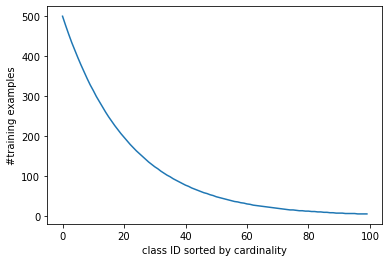

In [12]:
#preview img_num_per_cls distribution
plt.plot(img_num_per_cls)
plt.xlabel('class ID sorted by cardinality')
plt.ylabel('#training examples')


In [13]:
dataloaders = {set_name: DataLoader(datasets[set_name],
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    ) # num_work can be set to batch_size
               for set_name in ['train', 'test']} # 'train',





print('#train batch:', len(dataloaders['train']), '\t#test batch:', len(dataloaders['test']))

#train batch: 678 	#test batch: 625


In [14]:
b=[0]*100
for f in range(100):
    b[f]=f

In [15]:
# Finding number of images
num_of_img=[0]*100
for v in range(len(new_labelList)):
    for t in range(len(b)):
        
        if new_labelList[v]==b[t]:
            num_of_img[t]+=1

In [16]:
# Finding tail classes
tail_classes=[]
for t in range(len(b)):
    if num_of_img[t]<10:
        tail_classes.append(t)

In [17]:
tail_classes

[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Text(0, 0.5, ' No. of training examples')

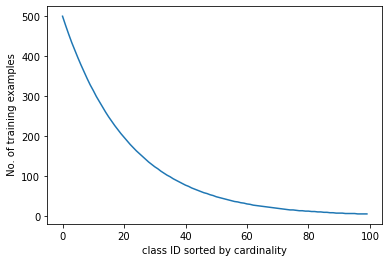

In [18]:
#preview training data representation
plt.plot(num_of_img)
plt.xlabel('class ID sorted by cardinality')
plt.ylabel(' No. of training examples')

In [22]:
print(len(datasets['train']))

10847


In [19]:
dataset_sizes={'train':10847,
               'test':10000}


In [27]:
dataset_sizes['train']

10847

In [20]:
traindata_labels=new_labelList
traindata_labels
 

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [21]:
testdata_labels=labelList
testdata_labels

[49,
 33,
 72,
 51,
 71,
 92,
 15,
 14,
 23,
 0,
 71,
 75,
 81,
 69,
 40,
 43,
 92,
 97,
 70,
 53,
 70,
 49,
 75,
 29,
 21,
 16,
 39,
 8,
 8,
 70,
 20,
 61,
 41,
 93,
 56,
 73,
 58,
 11,
 25,
 37,
 63,
 24,
 49,
 73,
 56,
 22,
 41,
 58,
 75,
 17,
 4,
 6,
 9,
 57,
 2,
 32,
 71,
 52,
 42,
 69,
 77,
 27,
 15,
 65,
 7,
 35,
 43,
 82,
 63,
 92,
 66,
 90,
 67,
 91,
 32,
 32,
 82,
 10,
 77,
 22,
 71,
 78,
 54,
 6,
 29,
 89,
 78,
 33,
 11,
 67,
 22,
 18,
 27,
 21,
 13,
 21,
 50,
 75,
 37,
 35,
 26,
 83,
 47,
 95,
 43,
 69,
 76,
 17,
 57,
 59,
 25,
 20,
 27,
 0,
 9,
 71,
 8,
 43,
 57,
 56,
 85,
 10,
 19,
 92,
 33,
 20,
 21,
 50,
 70,
 46,
 11,
 16,
 1,
 74,
 33,
 91,
 60,
 64,
 52,
 23,
 4,
 11,
 52,
 37,
 24,
 95,
 25,
 39,
 51,
 58,
 58,
 77,
 18,
 59,
 45,
 66,
 58,
 20,
 24,
 4,
 36,
 8,
 87,
 10,
 30,
 47,
 54,
 99,
 51,
 83,
 9,
 37,
 4,
 83,
 95,
 83,
 32,
 73,
 18,
 40,
 39,
 64,
 22,
 80,
 28,
 28,
 40,
 95,
 98,
 83,
 12,
 24,
 45,
 13,
 94,
 24,
 58,
 63,
 7,
 87,
 6,
 78,
 68,
 60,


In [ ]:
code_m=torch.randint(0,2,(100,10)).unique

In [ ]:
code_m

In [23]:
# Creating a gold matrix(actually a code matrix) using output of code_m
gold_matrix=[[1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [0, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 0, 0, 1, 1, 0, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
        [0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 1, 1, 0, 0, 1, 1, 0, 1, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 0, 0, 1, 1, 1],
        [1, 0, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
        [1, 0, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [1, 0, 1, 1, 0, 0, 0, 0, 1, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
        [1, 1, 0, 1, 0, 1, 1, 0, 1, 0],
        [0, 1, 1, 0, 1, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 0, 0, 1, 0, 0, 1, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 1, 0, 0, 1, 0],
        [1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 1, 1, 0, 0]]

In [25]:
gold_matrix=torch.tensor(gold_matrix)

In [28]:
from tqdm import tqdm

In [31]:
# Defining train model

true_value=[0]*100
pred_value=[0]*100

def train_model(model, criterion, optimizer, scheduler, num_epochs=8):
    since = time.time()



    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                
                inputs = inputs.to(device)
                labels = labels.to(device)
                ## defining modi_label according to the batch_size(or len of labels)
                modi_labels=torch.zeros(len(labels))
                

                index=[0]*len(labels)    
                for h in range(len(labels)):

                            modi_labels[h]=labels[h][0,0].int()
              
                if phase=='test':  
                      for g in range(len(labels)):  
                            m=modi_labels[g]

                            m=m.int()
                            true_value[m]+=1
                            index[g]=m

                  
                else:
                        pass
   
                outputs = model(inputs)
                m=nn.Softmax(dim=1)
                out=torch.zeros(len(labels),10)


                out=m(outputs)



                print(' ',modi_labels.shape)




                preds=torch.zeros(len(labels))
                preds=preds.int()                    

                for s in range(len(labels)):

                    for a in range(100):
                        # finding dot product of each combination of a out array with each row of gold_matrix and max dot product value chosen as closest codeword

                        max=0
                        dot_product=np.dot(out[s].detach().numpy(),gold_matrix[a].detach().numpy())
                        if dot_product>max:
                           max=dot_product
                           preds[s]=a                    
    
                

                new_label=torch.zeros(len(labels))

                target_code=torch.zeros(len(labels),10)


                print(preds)

                new_label=modi_labels.long()
                for g in range(len(labels)):
                       l=new_label[g] 
                       target_code[g]=gold_matrix[l]
    


                # forward
                # track history if only in train
                with torch.set_grad_enabled( phase=='train'):
                   
#                       outputs = model(inputs)
                      
                  
                     

                                            
                      
                      
                      
                      loss = criterion(out
                                       ,target_code)
                      
                   
                      


                         

                      # backward + optimize only if in training phase
                      if phase == 'train':
                       
                        print(len(labels),' ',labels[0],' ',out[0],' ',preds[0],' ',len(inputs),' ',target_code[0])
                        optimizer.zero_grad()

                        loss.backward()


                        optimizer.step()
                print (' ',len(preds),' ',len(modi_labels))
                # statistics
                running_loss += loss.item() * inputs.size(0)

                running_corrects += torch.sum(preds == modi_labels)


                if phase=='test':
                   
                  for g in range(len(labels)):
                    if preds[g]== modi_labels[g]:
                        pred_value[index[g]]=pred_value[index[g]]+1
                    else:
                        pass
            if phase == 'train':
                 scheduler.step()                    


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
             
        torch.save(model.state_dict(), 'C:\\Users\HP\\CIFAR100_L_T\\datasets\\cifar-100-python\\model'+str(epoch)+'.pt')
        torch.save(optimizer.state_dict(), 'C:\\Users\HP\\CIFAR100_L_T\\datasets\\cifar-100-python\\optimizer'+str(epoch)+'.pt')
        torch.save(scheduler.state_dict(), 'C:\\Users\HP\\CIFAR100_L_T\\datasets\\cifar-100-python\\scheduler'+str(epoch)+'.pt')     



        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    
    return model

In [32]:
##  Freezing the pre-trained model layer
model=models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

##Fine Tuning Conv Net 
model.classifier=nn.Linear(25088,10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model=train_model(model,criterion,optimizer,scheduler,num_epochs=8)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Epoch 0/7
----------
  torch.Size([16])
tensor([99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99],
       dtype=torch.int32)
16   tensor([[16.]])   tensor([0.0058, 0.0124, 0.3825, 0.0292, 0.0197, 0.1494, 0.1110, 0.0634, 0.1775,
        0.0492], grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([1., 0., 0., 1., 0., 0., 0., 1., 1., 1.])
  16   16
  torch.Size([16])
tensor([99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99],
       dtype=torch.int32)
16   tensor([[1.]])   tensor([0.0598, 0.0126, 0.0021, 0.1013, 0.0346, 0.0158, 0.3752, 0.1529, 0.1648,
        0.0808], grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 1.])
  16   16
  torch.Size([16])
tensor([99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99],
       dtype=torch.int32)
16   tensor([[25.]])   tensor([4.9482e-03, 2.9086e-04, 1.7988e-06, 6.7046e-01, 1.7140e-02, 5.6720e-04,
        1.2674e-02, 2.0155e-01, 6

 12%|██████████▍                                                                        | 1/8 [07:28<52:18, 448.36s/it]


Epoch 1/7
----------
  torch.Size([16])
tensor([99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99],
       dtype=torch.int32)
16   tensor([[18.]])   tensor([1.2612e-44, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0431e-42, 4.8743e-35, 0.0000e+00],
       grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 0.])
  16   16
  torch.Size([16])
tensor([99, 99, 99, 99, 99, 99, 99, 99, 98, 99, 99, 99, 98, 99, 99, 99],
       dtype=torch.int32)
16   tensor([[6.]])   tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4608e-39, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 4.2039e-45, 0.0000e+00],
       grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 0.])
  16   16
  torch.Size([16])
tensor([99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 98],
       dtype=torch.int32)
16   tensor([[21.]])   tensor([1.7134e-34

 25%|████████████████████▊                                                              | 2/8 [14:54<44:43, 447.17s/it]


Epoch 2/7
----------
  torch.Size([16])
tensor([99, 99, 99, 98, 98, 98, 95, 99, 98, 99, 99, 99, 99, 98, 99, 99],
       dtype=torch.int32)
16   tensor([[7.]])   tensor([1.4369e-26, 2.2680e-23, 1.5922e-41, 1.1573e-07, 1.0000e+00, 1.8293e-28,
        5.0703e-20, 5.5472e-19, 2.8094e-18, 5.3698e-41],
       grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 0.])
  16   16
  torch.Size([16])
tensor([99, 99, 99, 98, 97, 99, 99, 99, 97, 98, 99, 99, 97, 99, 98, 99],
       dtype=torch.int32)
16   tensor([[3.]])   tensor([1.2836e-41, 0.0000e+00, 0.0000e+00, 9.9997e-01, 2.5879e-05, 0.0000e+00,
        0.0000e+00, 3.4780e-38, 1.9320e-16, 0.0000e+00],
       grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([1., 0., 1., 0., 1., 1., 0., 1., 1., 0.])
  16   16
  torch.Size([16])
tensor([99, 98, 99, 99, 97, 99, 99, 99, 98, 98, 97, 99, 98, 97, 98, 99],
       dtype=torch.int32)
16   tensor([[29.]])   tensor([0.0000e+00,

 38%|███████████████████████████████▏                                                   | 3/8 [22:18<37:07, 445.42s/it]


Epoch 3/7
----------
  torch.Size([16])
tensor([99, 97, 99, 98, 99, 98, 98, 99, 98, 99, 99, 98, 98, 98, 99, 99],
       dtype=torch.int32)
16   tensor([[14.]])   tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        3.1703e-30, 0.0000e+00, 1.2261e-30, 0.0000e+00],
       grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 1.])
  16   16
  torch.Size([16])
tensor([99, 99, 98, 99, 98, 98, 99, 99, 99, 99, 98, 98, 98, 98, 99, 98],
       dtype=torch.int32)
16   tensor([[8.]])   tensor([9.8091e-45, 6.0256e-44, 0.0000e+00, 0.0000e+00, 5.6939e-04, 0.0000e+00,
        1.0623e-15, 3.2855e-37, 9.9943e-01, 0.0000e+00],
       grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 1.])
  16   16
  torch.Size([16])
tensor([98, 99, 97, 99, 98, 99, 98, 98, 99, 98, 99, 98, 98, 98, 98, 99],
       dtype=torch.int32)
16   tensor([[39.]])   tensor([0., 0., 0.

 50%|█████████████████████████████████████████▌                                         | 4/8 [29:40<29:36, 444.18s/it]


Epoch 4/7
----------
  torch.Size([16])
tensor([99, 98, 98, 99, 99, 98, 98, 99, 99, 98, 99, 99, 99, 99, 95, 95],
       dtype=torch.int32)
16   tensor([[7.]])   tensor([7.8390e-27, 3.4227e-27, 8.4078e-45, 8.7950e-18, 8.4130e-09, 8.0712e-34,
        1.6468e-14, 2.6676e-29, 1.0000e+00, 7.6374e-36],
       grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 0.])
  16   16
  torch.Size([16])
tensor([99, 98, 98, 99, 98, 98, 99, 98, 99, 99, 99, 98, 98, 99, 99, 98],
       dtype=torch.int32)
16   tensor([[14.]])   tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 1.])
  16   16
  torch.Size([16])
tensor([99, 99, 99, 99, 97, 98, 99, 98, 98, 99, 98, 98, 99, 97, 98, 98],
       dtype=torch.int32)
16   tensor([[51.]])   tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        5.4159e-23, 0.0000e+00, 0

 62%|███████████████████████████████████████████████████▉                               | 5/8 [37:02<22:09, 443.29s/it]


Epoch 5/7
----------
  torch.Size([16])
tensor([98, 97, 98, 95, 99, 99, 99, 97, 98, 99, 95, 99, 99, 99, 98, 98],
       dtype=torch.int32)
16   tensor([[8.]])   tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8632e-12, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
       grad_fn=<SelectBackward0>)   tensor(98, dtype=torch.int32)   16   tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 1.])
  16   16
  torch.Size([16])
tensor([98, 99, 99, 98, 95, 98, 98, 99, 98, 99, 98, 99, 99, 98, 98, 99],
       dtype=torch.int32)
16   tensor([[12.]])   tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], grad_fn=<SelectBackward0>)   tensor(98, dtype=torch.int32)   16   tensor([1., 0., 0., 1., 1., 0., 0., 1., 1., 1.])
  16   16
  torch.Size([16])
tensor([95, 98, 99, 99, 98, 98, 99, 99, 98, 99, 98, 98, 98, 98, 97, 98],
       dtype=torch.int32)
16   tensor([[0.]])   tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>)   tensor(95, dtype=torch.int32)   16  

 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [44:28<14:48, 444.27s/it]


Epoch 6/7
----------
  torch.Size([16])
tensor([99, 95, 98, 98, 98, 99, 99, 99, 98, 95, 98, 98, 97, 99, 98, 99],
       dtype=torch.int32)
16   tensor([[5.]])   tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.7340e-40, 0.0000e+00, 1.0000e+00, 0.0000e+00],
       grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.])
  16   16
  torch.Size([16])
tensor([95, 98, 98, 99, 99, 98, 99, 98, 99, 99, 99, 98, 98, 98, 99, 98],
       dtype=torch.int32)
16   tensor([[0.]])   tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>)   tensor(95, dtype=torch.int32)   16   tensor([1., 1., 0., 0., 0., 1., 1., 0., 0., 0.])
  16   16
  torch.Size([16])
tensor([99, 98, 99, 98, 99, 99, 98, 98, 99, 97, 99, 98, 98, 99, 99, 99],
       dtype=torch.int32)
16   tensor([[52.]])   tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0255e-31, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.

 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [51:48<07:23, 443.10s/it]


Epoch 7/7
----------
  torch.Size([16])
tensor([99, 98, 98, 98, 99, 98, 99, 99, 98, 97, 99, 99, 99, 98, 98, 99],
       dtype=torch.int32)
16   tensor([[23.]])   tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.3057e-37, 0.0000e+00, 1.0000e+00, 0.0000e+00],
       grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([0., 1., 1., 0., 0., 1., 1., 0., 1., 0.])
  16   16
  torch.Size([16])
tensor([99, 95, 98, 95, 98, 98, 98, 98, 98, 99, 98, 98, 95, 98, 97, 99],
       dtype=torch.int32)
16   tensor([[42.]])   tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.2886e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<SelectBackward0>)   tensor(99, dtype=torch.int32)   16   tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 1.])
  16   16
  torch.Size([16])
tensor([99, 95, 97, 98, 99, 99, 99, 98, 99, 99, 99, 99, 99, 99, 99, 98],
       dtype=torch.int32)
16   tensor([[13.]])   tensor([0.0000e+0

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [59:06<00:00, 443.32s/it]


Training complete in 59m 7s


In [27]:
# tail_class=[]
# tail_acc=[]
# for s in range(100):
#     if true_value[s]<365:
#         print(b[s])
#         tail_class.append(b[s])
#         tail_acc.append(Acc_class[s])
        

In [131]:
# tail_acc

[5.260869565217392,
 7.760869565217392,
 5.53125,
 8.272727272727273,
 7.28,
 5.806451612903226,
 6.6415094339622645,
 7.659574468085107,
 6.169491525423729,
 4.986301369863014,
 5.933333333333334,
 9.333333333333334]

In [109]:
# Acc_class

[10.459854014598541,
 5.6521739130434785,
 5.522388059701493,
 7.480769230769231,
 5.90625,
 5.428571428571429,
 5.707692307692308,
 6.413793103448276,
 5.260869565217392,
 6.423728813559322,
 4.6419753086419755,
 5.333333333333333,
 4.868421052631579,
 7.875,
 6.0,
 7.760869565217392,
 5.594202898550725,
 6.839285714285714,
 6.383333333333334,
 7.037735849056604,
 7.9787234042553195,
 9.605263157894736,
 5.606060606060606,
 5.53125,
 7.612244897959184,
 6.962962962962963,
 6.473684210526316,
 8.104166666666666,
 4.8625,
 5.861538461538461,
 7.215686274509804,
 8.883720930232558,
 6.943396226415095,
 8.272727272727273,
 7.28,
 6.433333333333334,
 6.875,
 7.3076923076923075,
 6.689655172413793,
 9.538461538461538,
 5.426470588235294,
 6.836363636363636,
 5.636363636363637,
 5.391304347826087,
 6.0,
 6.87719298245614,
 7.829787234042553,
 8.355555555555556,
 10.444444444444445,
 5.6231884057971016,
 5.806451612903226,
 5.841269841269841,
 6.763636363636364,
 5.257142857142857,
 6.6428571

<BarContainer object of 12 artists>

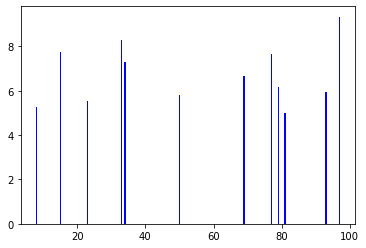

In [133]:
# plt.bar(tail_class,tail_acc,color='blue',width=0.4)

<BarContainer object of 100 artists>

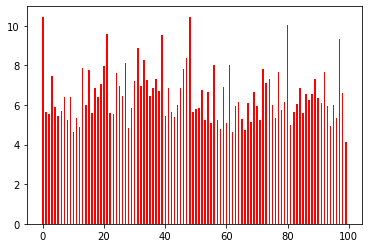

In [134]:
# plt.bar(b, Acc_class, color='red',
#         width = 0.5)

In [31]:
from sklearn.multiclass import OutputCodeClassifier

# define the binary classification model
# model = LogisticRegression()
# define the ecoc model
ecoc = OutputCodeClassifier(model, code_size=0.1, random_state=1)

In [32]:
ecoc

OutputCodeClassifier(code_size=0.1,
                     estimator=VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), st...
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Linear(in_features=25088, out_features=100, bias=True)
),
                     random_state=1)

In [36]:
ecoc=ecoc.fit(new_imgList, new_labelList)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [32]:
new_imgList[1]

array([[[ 73, 109,  97, ...,  88,  84, 114],
        [ 69, 113, 110, ...,  93,  91, 118],
        [ 92, 107,  91, ...,  91,  96, 104],
        ...,
        [ 60,  51,  47, ...,  83,  90,  85],
        [ 63,  46,  63, ...,  82,  87,  79],
        [ 71,  45,  67, ...,  69,  83,  65]],

       [[ 76, 111, 104, ..., 104, 101, 123],
        [ 69, 108, 102, ..., 104, 105, 126],
        [ 93, 104,  87, ..., 100, 107, 114],
        ...,
        [ 70,  59,  51, ...,  84,  89,  95],
        [ 73,  51,  62, ...,  86,  95,  90],
        [ 79,  47,  69, ...,  71,  81,  62]],

       [[ 50,  83,  70, ...,  56,  48,  86],
        [ 48,  85,  82, ...,  64,  66,  91],
        [ 70,  81,  66, ...,  71,  74,  78],
        ...,
        [ 46,  41,  33, ...,  58,  64,  58],
        [ 52,  35,  47, ...,  53,  62,  57],
        [ 52,  31,  48, ...,  47,  58,  43]]], dtype=uint8)

In [39]:
torch.reshape?

In [42]:
type(new_imgList)

numpy.ndarray

In [41]:
type(new_labelList)

list

In [33]:
tens_new_imgList=torch.from_numpy(new_imgList)

In [34]:
type(tens_new_imgList)

torch.Tensor

In [35]:
tens_new_imgList.size()

torch.Size([10847, 3, 32, 32])

In [36]:
tens_new_imgList.view(10847,32*32*3)

tensor([[250, 248, 247,  ..., 194, 207, 228],
        [ 73, 109,  97,  ...,  47,  58,  43],
        [228, 229, 230,  ..., 192, 202, 224],
        ...,
        [215, 214, 216,  ..., 164, 164, 165],
        [197, 198, 198,  ..., 175, 176, 176],
        [ 87,  58,  53,  ...,  57,  78,  90]], dtype=torch.uint8)

In [39]:
ecoc=ecoc.fit(tens_new_imgList.view(10847,32*32*3), new_labelList)

ValueError: The base estimator should implement decision_function or predict_proba!